# Descripción del proyecto

La compañía Sweet Lift Taxi ha recopilado datos históricos sobre pedidos de taxis en los aeropuertos. Para atraer a más conductores durante las horas pico, necesitamos predecir la cantidad de pedidos de taxis para la próxima hora. Construye un modelo para dicha predicción.

La métrica RECM en el conjunto de prueba no debe ser superior a 48.

## Instrucciones del proyecto.

1. Descarga los datos y haz el remuestreo por una hora.
2. Analiza los datos
3. Entrena diferentes modelos con diferentes hiperparámetros. La muestra de prueba debe ser el 10% del conjunto de datos inicial.4. Prueba los datos usando la muestra de prueba y proporciona una conclusión.

## Descripción de los datos

Los datos se almacenan en el archivo `taxi.csv`. 	
El número de pedidos está en la columna `num_orders`.

## Preparación

In [1]:
# Importar librerias
import matplotlib.pyplot as plt
import pandas as pd
import xgboost as xgb
from sklearn.model_selection import train_test_split, GridSearchCV, TimeSeriesSplit
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from catboost import CatBoostRegressor
from statsmodels.tsa.seasonal import seasonal_decompose

In [2]:
# Cargar de la data
df_taxi = pd.read_csv('/datasets/taxi.csv', index_col=[0], parse_dates=[0])

In [3]:
# Valores ausentes 
df_taxi.isna().sum()

num_orders    0
dtype: int64

In [4]:
# Verificar si las fechas estan ordenadas 
df_taxi.index.is_monotonic_increasing

True

In [5]:
# Informacion general 
df_taxi.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 26496 entries, 2018-03-01 00:00:00 to 2018-08-31 23:50:00
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   num_orders  26496 non-null  int64
dtypes: int64(1)
memory usage: 414.0 KB


En el dataframe hay 26496 datos que van desde 1 de marzo del 2018 al 31 de agosto del 2018, no existen valores ausentes y estan ordenados correctamente  

## Análisis

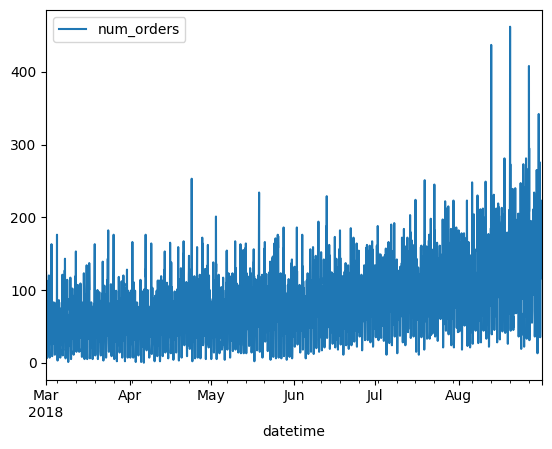

In [6]:
# Remuestreo por hora 
df_taxi = df_taxi.resample('1H').sum()
# Grafica 
df_taxi.plot()
plt.show()

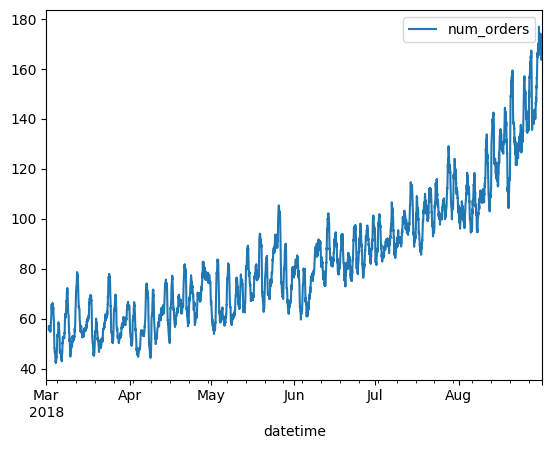

In [7]:
# Medias moviles 
df_taxi.rolling(24).mean().plot()
plt.show()

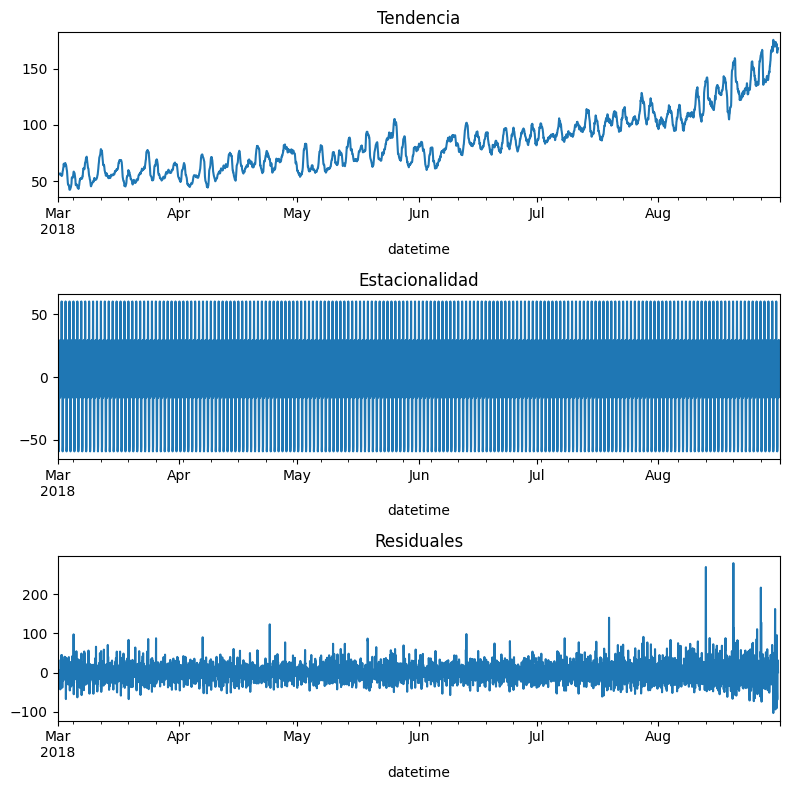

In [8]:
# Descomponer los datos 
decomposed = seasonal_decompose(df_taxi)

plt.figure(figsize=(8, 8))

plt.subplot(311)
decomposed.trend.plot(ax=plt.gca())
plt.title('Tendencia')
plt.subplot(312)
decomposed.seasonal.plot(ax=plt.gca())
plt.title('Estacionalidad')
plt.subplot(313)
decomposed.resid.plot(ax=plt.gca())
plt.title('Residuales')


plt.tight_layout() 

La serie de tiempo tiene una tendecia positiva y no quiene un ciclo particular

## Formación

In [9]:
def make_features(df, max_lag):
    df['year'] = df.index.year
    df['month'] = df.index.month
    df['day'] = df.index.day
    df['day_of_week'] = df.index.dayofweek   

    for lag in range(1, max_lag + 1):
        df[f'lag_{lag}'] = df['num_orders'].shift(lag)

In [10]:
# Colocamos 48 resagos 
make_features(df_taxi, 48)
# Visualizar el dataframe creado
df_taxi

,num_orders,year,month,day,day_of_week,lag_1,lag_2,lag_3,lag_4,lag_5,...,lag_39,lag_40,lag_41,lag_42,lag_43,lag_44,lag_45,lag_46,lag_47,lag_48
datetime,,,,,,,,,,,,,,,,,,,,,
2018-03-01 00:00:00,124,2018,3,1,3,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 01:00:00,85,2018,3,1,3,124.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 02:00:00,71,2018,3,1,3,85.0,124.0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 03:00:00,66,2018,3,1,3,71.0,85.0,124.0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 04:00:00,43,2018,3,1,3,66.0,71.0,85.0,124.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2018-08-31 19:00:00,136,2018,8,31,4,207.0,217.0,197.0,116.0,133.0,...,186.0,193.0,232.0,217.0,216.0,265.0,177.0,170.0,191.0,169.0
2018-08-31 20:00:00,154,2018,8,31,4,136.0,207.0,217.0,197.0,116.0,...,56.0,186.0,193.0,232.0,217.0,216.0,265.0,177.0,170.0,191.0
2018-08-31 21:00:00,159,2018,8,31,4,154.0,136.0,207.0,217.0,197.0,...,13.0,56.0,186.0,193.0,232.0,217.0,216.0,265.0,177.0,170.0


In [11]:
# Dividir el dataframe en entrenamiento y prueba 
train, test = train_test_split(df_taxi, shuffle=False, test_size=0.1)

# Eliminar las filas con valores ausentes
train.dropna(inplace=True) 
test.dropna(inplace=True)

# Dividir las características y el objetivo
features_train = train.drop(['num_orders'], axis=1)
target_train = train['num_orders']
features_test = test.drop(['num_orders'], axis = 1)
target_test = test['num_orders']


/tmp/ipykernel_65/1981891307.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train.dropna(inplace=True)
/tmp/ipykernel_65/1981891307.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test.dropna(inplace=True)


In [12]:
# Regresion lineal
model = LinearRegression()
model.fit(features_train, target_train)

pred_train = model.predict(features_train)
pred_test = model.predict(features_test)

print("RECM para el conjunto de entrenamiento:", mean_squared_error(target_train, pred_train) ** 0.5) 
print("RECM para el conjunto de prueba:", mean_squared_error(target_test, pred_test) ** 0.5) 

RECM para el conjunto de entrenamiento: 23.347323316371693
RECM para el conjunto de prueba: 43.156705637228


In [13]:
# Bosque aleatorio
model = RandomForestRegressor(random_state=54321)

# Hiperparámetros a buscar
param_grid = {
    'max_depth': [20],
    'min_samples_leaf': [5],
    'min_samples_split': [2],
    'n_estimators': [150]
}

grid_search = GridSearchCV(model, param_grid=param_grid, scoring='neg_mean_squared_error', cv=TimeSeriesSplit(n_splits=5), n_jobs=-1)
grid_search.fit(features_train, target_train)
print(f'Mejores hiperprámetros: {grid_search.best_params_}')
predicts = grid_search.predict(features_test)

print("RECM para el conjunto de prueba:", mean_squared_error(target_test, predicts) ** 0.5) 

Mejores hiperprámetros: {'max_depth': 20, 'min_samples_leaf': 5, 'min_samples_split': 2, 'n_estimators': 150}
RECM para el conjunto de prueba: 41.703969678709804


In [14]:
# Catboost 
model = CatBoostRegressor()

# Establecer los hiperparámetros a buscar
param_grid = {
    'depth': [8],
    'iterations': [1000],
    'l2_leaf_reg': [1],
    'learning_rate': [0.01],
    'subsample': [0.8],
    'rsm': [0.9]
}

tscv = TimeSeriesSplit(n_splits=5)
grid_search = GridSearchCV(model, param_grid=param_grid, scoring='neg_mean_squared_error', cv=5, n_jobs=-1)
grid_search.fit(features_train, target_train)
best_params = grid_search.best_params_
print(f'Mejores hiperparámetros: {best_params}')
best_model = grid_search.best_estimator_
pred_test = grid_search.predict(features_test)
print("RECM para el conjunto de prueba:", mean_squared_error(target_test, pred_test) ** 0.5)

0:	learn: 38.6717250	total: 79.1ms	remaining: 1m 19s
1:	learn: 38.4774003	total: 117ms	remaining: 58.6s
2:	learn: 38.3141161	total: 155ms	remaining: 51.5s
3:	learn: 38.1301744	total: 193ms	remaining: 48s
4:	learn: 37.9465099	total: 219ms	remaining: 43.5s
5:	learn: 37.7758466	total: 257ms	remaining: 42.5s
6:	learn: 37.5933491	total: 294ms	remaining: 41.7s
7:	learn: 37.4281065	total: 334ms	remaining: 41.4s
8:	learn: 37.2515484	total: 365ms	remaining: 40.2s
9:	learn: 37.0794018	total: 404ms	remaining: 40s
10:	learn: 36.9078919	total: 432ms	remaining: 38.9s
11:	learn: 36.7377807	total: 472ms	remaining: 38.9s
12:	learn: 36.5782613	total: 511ms	remaining: 38.8s
13:	learn: 36.4214138	total: 539ms	remaining: 37.9s
14:	learn: 36.2585101	total: 578ms	remaining: 38s
15:	learn: 36.1150285	total: 617ms	remaining: 37.9s
16:	learn: 35.9510624	total: 653ms	remaining: 37.8s
17:	learn: 35.7908214	total: 681ms	remaining: 37.1s
18:	learn: 35.6373743	total: 722ms	remaining: 37.3s
19:	learn: 35.4816590	tota

163:	learn: 24.5255759	total: 5.8s	remaining: 29.6s
164:	learn: 24.4917904	total: 5.84s	remaining: 29.6s
165:	learn: 24.4575535	total: 5.88s	remaining: 29.5s
166:	learn: 24.4168564	total: 5.91s	remaining: 29.5s
167:	learn: 24.3849413	total: 5.95s	remaining: 29.5s
168:	learn: 24.3514673	total: 5.99s	remaining: 29.4s
169:	learn: 24.3189003	total: 6.02s	remaining: 29.4s
170:	learn: 24.2777503	total: 6.06s	remaining: 29.4s
171:	learn: 24.2443499	total: 6.09s	remaining: 29.3s
172:	learn: 24.2122247	total: 6.13s	remaining: 29.3s
173:	learn: 24.1797168	total: 6.18s	remaining: 29.3s
174:	learn: 24.1467446	total: 6.22s	remaining: 29.3s
175:	learn: 24.1097707	total: 6.25s	remaining: 29.3s
176:	learn: 24.0773547	total: 6.29s	remaining: 29.3s
177:	learn: 24.0448275	total: 6.32s	remaining: 29.2s
178:	learn: 24.0145347	total: 6.36s	remaining: 29.2s
179:	learn: 23.9865574	total: 6.39s	remaining: 29.1s
180:	learn: 23.9521920	total: 6.43s	remaining: 29.1s
181:	learn: 23.9218509	total: 6.47s	remaining: 

324:	learn: 20.9666199	total: 11.5s	remaining: 23.9s
325:	learn: 20.9506496	total: 11.5s	remaining: 23.9s
326:	learn: 20.9369170	total: 11.6s	remaining: 23.8s
327:	learn: 20.9238375	total: 11.6s	remaining: 23.8s
328:	learn: 20.9058266	total: 11.6s	remaining: 23.7s
329:	learn: 20.8966641	total: 11.7s	remaining: 23.7s
330:	learn: 20.8835047	total: 11.7s	remaining: 23.7s
331:	learn: 20.8721308	total: 11.8s	remaining: 23.6s
332:	learn: 20.8576364	total: 11.8s	remaining: 23.6s
333:	learn: 20.8441463	total: 11.8s	remaining: 23.6s
334:	learn: 20.8337683	total: 11.9s	remaining: 23.5s
335:	learn: 20.8154003	total: 11.9s	remaining: 23.5s
336:	learn: 20.8043848	total: 11.9s	remaining: 23.5s
337:	learn: 20.7903621	total: 12s	remaining: 23.4s
338:	learn: 20.7761048	total: 12s	remaining: 23.4s
339:	learn: 20.7584786	total: 12s	remaining: 23.3s
340:	learn: 20.7466331	total: 12.1s	remaining: 23.3s
341:	learn: 20.7308852	total: 12.1s	remaining: 23.3s
342:	learn: 20.7149464	total: 12.1s	remaining: 23.2s

480:	learn: 19.1311875	total: 17s	remaining: 18.4s
481:	learn: 19.1249393	total: 17s	remaining: 18.3s
482:	learn: 19.1127201	total: 17.1s	remaining: 18.3s
483:	learn: 19.0983386	total: 17.1s	remaining: 18.2s
484:	learn: 19.0896253	total: 17.2s	remaining: 18.2s
485:	learn: 19.0781455	total: 17.2s	remaining: 18.2s
486:	learn: 19.0665292	total: 17.2s	remaining: 18.1s
487:	learn: 19.0589594	total: 17.2s	remaining: 18.1s
488:	learn: 19.0491842	total: 17.3s	remaining: 18.1s
489:	learn: 19.0368375	total: 17.3s	remaining: 18s
490:	learn: 19.0274626	total: 17.4s	remaining: 18s
491:	learn: 19.0150515	total: 17.4s	remaining: 17.9s
492:	learn: 19.0030585	total: 17.4s	remaining: 17.9s
493:	learn: 18.9960771	total: 17.4s	remaining: 17.9s
494:	learn: 18.9830229	total: 17.5s	remaining: 17.8s
495:	learn: 18.9745911	total: 17.5s	remaining: 17.8s
496:	learn: 18.9686268	total: 17.6s	remaining: 17.8s
497:	learn: 18.9588861	total: 17.6s	remaining: 17.7s
498:	learn: 18.9441630	total: 17.6s	remaining: 17.7s
4

640:	learn: 17.6713878	total: 22.6s	remaining: 12.6s
641:	learn: 17.6615723	total: 22.6s	remaining: 12.6s
642:	learn: 17.6552215	total: 22.6s	remaining: 12.6s
643:	learn: 17.6495207	total: 22.7s	remaining: 12.5s
644:	learn: 17.6428765	total: 22.7s	remaining: 12.5s
645:	learn: 17.6386307	total: 22.7s	remaining: 12.5s
646:	learn: 17.6299308	total: 22.8s	remaining: 12.4s
647:	learn: 17.6244091	total: 22.8s	remaining: 12.4s
648:	learn: 17.6173851	total: 22.8s	remaining: 12.4s
649:	learn: 17.6136866	total: 22.9s	remaining: 12.3s
650:	learn: 17.6057468	total: 22.9s	remaining: 12.3s
651:	learn: 17.5980608	total: 23s	remaining: 12.3s
652:	learn: 17.5902868	total: 23s	remaining: 12.2s
653:	learn: 17.5806286	total: 23s	remaining: 12.2s
654:	learn: 17.5731012	total: 23.1s	remaining: 12.1s
655:	learn: 17.5620477	total: 23.1s	remaining: 12.1s
656:	learn: 17.5499639	total: 23.1s	remaining: 12.1s
657:	learn: 17.5445285	total: 23.2s	remaining: 12s
658:	learn: 17.5376030	total: 23.2s	remaining: 12s
659

796:	learn: 16.5393060	total: 28.1s	remaining: 7.15s
797:	learn: 16.5337852	total: 28.1s	remaining: 7.11s
798:	learn: 16.5308235	total: 28.1s	remaining: 7.08s
799:	learn: 16.5273114	total: 28.2s	remaining: 7.04s
800:	learn: 16.5191469	total: 28.2s	remaining: 7.01s
801:	learn: 16.5083364	total: 28.2s	remaining: 6.97s
802:	learn: 16.5016049	total: 28.3s	remaining: 6.93s
803:	learn: 16.4970160	total: 28.3s	remaining: 6.9s
804:	learn: 16.4886709	total: 28.3s	remaining: 6.86s
805:	learn: 16.4812603	total: 28.4s	remaining: 6.83s
806:	learn: 16.4734501	total: 28.4s	remaining: 6.79s
807:	learn: 16.4674711	total: 28.4s	remaining: 6.76s
808:	learn: 16.4604362	total: 28.5s	remaining: 6.72s
809:	learn: 16.4561396	total: 28.5s	remaining: 6.69s
810:	learn: 16.4486433	total: 28.5s	remaining: 6.65s
811:	learn: 16.4432501	total: 28.6s	remaining: 6.62s
812:	learn: 16.4337165	total: 28.6s	remaining: 6.58s
813:	learn: 16.4305879	total: 28.7s	remaining: 6.55s
814:	learn: 16.4259178	total: 28.7s	remaining: 

953:	learn: 15.4462082	total: 33.5s	remaining: 1.61s
954:	learn: 15.4440879	total: 33.5s	remaining: 1.58s
955:	learn: 15.4359720	total: 33.6s	remaining: 1.54s
956:	learn: 15.4296223	total: 33.6s	remaining: 1.51s
957:	learn: 15.4185160	total: 33.6s	remaining: 1.47s
958:	learn: 15.4098877	total: 33.7s	remaining: 1.44s
959:	learn: 15.4012267	total: 33.7s	remaining: 1.4s
960:	learn: 15.3971854	total: 33.7s	remaining: 1.37s
961:	learn: 15.3916767	total: 33.8s	remaining: 1.33s
962:	learn: 15.3837262	total: 33.8s	remaining: 1.3s
963:	learn: 15.3778553	total: 33.8s	remaining: 1.26s
964:	learn: 15.3736248	total: 33.9s	remaining: 1.23s
965:	learn: 15.3659267	total: 33.9s	remaining: 1.19s
966:	learn: 15.3573219	total: 33.9s	remaining: 1.16s
967:	learn: 15.3522045	total: 34s	remaining: 1.12s
968:	learn: 15.3444400	total: 34s	remaining: 1.09s
969:	learn: 15.3375472	total: 34s	remaining: 1.05s
970:	learn: 15.3299746	total: 34.1s	remaining: 1.02s
971:	learn: 15.3204334	total: 34.1s	remaining: 983ms
9

114:	learn: 26.4120143	total: 3.95s	remaining: 30.4s
115:	learn: 26.3535418	total: 3.98s	remaining: 30.4s
116:	learn: 26.2964403	total: 4.02s	remaining: 30.4s
117:	learn: 26.2392835	total: 4.05s	remaining: 30.3s
118:	learn: 26.1837744	total: 4.09s	remaining: 30.3s
119:	learn: 26.1322842	total: 4.12s	remaining: 30.2s
120:	learn: 26.0778833	total: 4.16s	remaining: 30.2s
121:	learn: 26.0256653	total: 4.2s	remaining: 30.2s
122:	learn: 25.9771911	total: 4.24s	remaining: 30.2s
123:	learn: 25.9202465	total: 4.28s	remaining: 30.2s
124:	learn: 25.8669360	total: 4.3s	remaining: 30.1s
125:	learn: 25.8188372	total: 4.34s	remaining: 30.1s
126:	learn: 25.7678057	total: 4.38s	remaining: 30.1s
127:	learn: 25.7177906	total: 4.42s	remaining: 30.1s
128:	learn: 25.6667454	total: 4.44s	remaining: 30s
129:	learn: 25.6177022	total: 4.48s	remaining: 30s
130:	learn: 25.5723083	total: 4.52s	remaining: 30s
131:	learn: 25.5205557	total: 4.54s	remaining: 29.9s
132:	learn: 25.4732157	total: 4.58s	remaining: 29.9s
1

272:	learn: 21.5208277	total: 9.36s	remaining: 24.9s
273:	learn: 21.5018867	total: 9.4s	remaining: 24.9s
274:	learn: 21.4881847	total: 9.43s	remaining: 24.9s
275:	learn: 21.4720224	total: 9.46s	remaining: 24.8s
276:	learn: 21.4546015	total: 9.5s	remaining: 24.8s
277:	learn: 21.4354927	total: 9.53s	remaining: 24.7s
278:	learn: 21.4203271	total: 9.56s	remaining: 24.7s
279:	learn: 21.4069991	total: 9.59s	remaining: 24.7s
280:	learn: 21.3856154	total: 9.63s	remaining: 24.6s
281:	learn: 21.3750724	total: 9.66s	remaining: 24.6s
282:	learn: 21.3550164	total: 9.69s	remaining: 24.6s
283:	learn: 21.3409861	total: 9.73s	remaining: 24.5s
284:	learn: 21.3219748	total: 9.76s	remaining: 24.5s
285:	learn: 21.3072799	total: 9.8s	remaining: 24.5s
286:	learn: 21.2926593	total: 9.82s	remaining: 24.4s
287:	learn: 21.2767740	total: 9.87s	remaining: 24.4s
288:	learn: 21.2606153	total: 9.89s	remaining: 24.3s
289:	learn: 21.2369104	total: 9.93s	remaining: 24.3s
290:	learn: 21.2229050	total: 9.97s	remaining: 24

428:	learn: 19.4154647	total: 14.7s	remaining: 19.6s
429:	learn: 19.4041676	total: 14.8s	remaining: 19.6s
430:	learn: 19.3948057	total: 14.8s	remaining: 19.5s
431:	learn: 19.3891170	total: 14.8s	remaining: 19.5s
432:	learn: 19.3807983	total: 14.9s	remaining: 19.5s
433:	learn: 19.3721557	total: 14.9s	remaining: 19.4s
434:	learn: 19.3530969	total: 14.9s	remaining: 19.4s
435:	learn: 19.3424904	total: 15s	remaining: 19.4s
436:	learn: 19.3295495	total: 15s	remaining: 19.3s
437:	learn: 19.3196592	total: 15s	remaining: 19.3s
438:	learn: 19.3140050	total: 15.1s	remaining: 19.3s
439:	learn: 19.3011215	total: 15.1s	remaining: 19.2s
440:	learn: 19.2865225	total: 15.1s	remaining: 19.2s
441:	learn: 19.2743344	total: 15.2s	remaining: 19.1s
442:	learn: 19.2667009	total: 15.2s	remaining: 19.1s
443:	learn: 19.2543290	total: 15.2s	remaining: 19.1s
444:	learn: 19.2427923	total: 15.3s	remaining: 19s
445:	learn: 19.2308734	total: 15.3s	remaining: 19s
446:	learn: 19.2266796	total: 15.4s	remaining: 19s
447:	

587:	learn: 17.9021888	total: 20.2s	remaining: 14.1s
588:	learn: 17.8899351	total: 20.2s	remaining: 14.1s
589:	learn: 17.8799808	total: 20.3s	remaining: 14.1s
590:	learn: 17.8730752	total: 20.3s	remaining: 14s
591:	learn: 17.8676448	total: 20.3s	remaining: 14s
592:	learn: 17.8603561	total: 20.4s	remaining: 14s
593:	learn: 17.8486519	total: 20.4s	remaining: 13.9s
594:	learn: 17.8364459	total: 20.4s	remaining: 13.9s
595:	learn: 17.8278515	total: 20.5s	remaining: 13.9s
596:	learn: 17.8140839	total: 20.5s	remaining: 13.8s
597:	learn: 17.8041438	total: 20.5s	remaining: 13.8s
598:	learn: 17.7970110	total: 20.6s	remaining: 13.8s
599:	learn: 17.7920892	total: 20.6s	remaining: 13.7s
600:	learn: 17.7878459	total: 20.6s	remaining: 13.7s
601:	learn: 17.7718525	total: 20.7s	remaining: 13.7s
602:	learn: 17.7661064	total: 20.7s	remaining: 13.6s
603:	learn: 17.7590733	total: 20.7s	remaining: 13.6s
604:	learn: 17.7496448	total: 20.8s	remaining: 13.6s
605:	learn: 17.7456085	total: 20.8s	remaining: 13.5s

746:	learn: 16.6439238	total: 25.7s	remaining: 8.71s
747:	learn: 16.6336672	total: 25.7s	remaining: 8.67s
748:	learn: 16.6244203	total: 25.8s	remaining: 8.64s
749:	learn: 16.6171848	total: 25.8s	remaining: 8.6s
750:	learn: 16.6082640	total: 25.8s	remaining: 8.57s
751:	learn: 16.6005002	total: 25.9s	remaining: 8.53s
752:	learn: 16.5933679	total: 25.9s	remaining: 8.5s
753:	learn: 16.5841718	total: 25.9s	remaining: 8.46s
754:	learn: 16.5786370	total: 26s	remaining: 8.43s
755:	learn: 16.5707334	total: 26s	remaining: 8.39s
756:	learn: 16.5628068	total: 26s	remaining: 8.36s
757:	learn: 16.5557044	total: 26.1s	remaining: 8.32s
758:	learn: 16.5470041	total: 26.1s	remaining: 8.29s
759:	learn: 16.5393818	total: 26.1s	remaining: 8.25s
760:	learn: 16.5324502	total: 26.2s	remaining: 8.22s
761:	learn: 16.5268379	total: 26.2s	remaining: 8.19s
762:	learn: 16.5148926	total: 26.2s	remaining: 8.15s
763:	learn: 16.5081025	total: 26.3s	remaining: 8.12s
764:	learn: 16.5015474	total: 26.3s	remaining: 8.08s
7

905:	learn: 15.5276618	total: 31.1s	remaining: 3.23s
906:	learn: 15.5248878	total: 31.2s	remaining: 3.2s
907:	learn: 15.5174297	total: 31.2s	remaining: 3.16s
908:	learn: 15.5071981	total: 31.3s	remaining: 3.13s
909:	learn: 15.5010007	total: 31.3s	remaining: 3.09s
910:	learn: 15.4958951	total: 31.3s	remaining: 3.06s
911:	learn: 15.4898317	total: 31.4s	remaining: 3.02s
912:	learn: 15.4818304	total: 31.4s	remaining: 2.99s
913:	learn: 15.4783326	total: 31.4s	remaining: 2.96s
914:	learn: 15.4729810	total: 31.5s	remaining: 2.92s
915:	learn: 15.4627430	total: 31.5s	remaining: 2.89s
916:	learn: 15.4571728	total: 31.5s	remaining: 2.85s
917:	learn: 15.4498401	total: 31.6s	remaining: 2.82s
918:	learn: 15.4445240	total: 31.6s	remaining: 2.78s
919:	learn: 15.4373295	total: 31.6s	remaining: 2.75s
920:	learn: 15.4326814	total: 31.7s	remaining: 2.71s
921:	learn: 15.4216616	total: 31.7s	remaining: 2.68s
922:	learn: 15.4170639	total: 31.7s	remaining: 2.65s
923:	learn: 15.4111142	total: 31.8s	remaining: 

64:	learn: 30.1675607	total: 2.24s	remaining: 32.3s
65:	learn: 30.0633283	total: 2.27s	remaining: 32.1s
66:	learn: 29.9578046	total: 2.31s	remaining: 32.2s
67:	learn: 29.8554688	total: 2.34s	remaining: 32.1s
68:	learn: 29.7593853	total: 2.38s	remaining: 32.1s
69:	learn: 29.6660111	total: 2.4s	remaining: 32s
70:	learn: 29.5655351	total: 2.44s	remaining: 32s
71:	learn: 29.4662037	total: 2.47s	remaining: 31.9s
72:	learn: 29.3790784	total: 2.51s	remaining: 31.9s
73:	learn: 29.2900390	total: 2.54s	remaining: 31.8s
74:	learn: 29.1976111	total: 2.58s	remaining: 31.8s
75:	learn: 29.1092629	total: 2.6s	remaining: 31.7s
76:	learn: 29.0179860	total: 2.64s	remaining: 31.7s
77:	learn: 28.9441400	total: 2.68s	remaining: 31.6s
78:	learn: 28.8546672	total: 2.71s	remaining: 31.7s
79:	learn: 28.7687815	total: 2.74s	remaining: 31.5s
80:	learn: 28.6830866	total: 2.78s	remaining: 31.5s
81:	learn: 28.5958045	total: 2.81s	remaining: 31.4s
82:	learn: 28.5164334	total: 2.85s	remaining: 31.4s
83:	learn: 28.4339

224:	learn: 22.2613948	total: 7.75s	remaining: 26.7s
225:	learn: 22.2413551	total: 7.79s	remaining: 26.7s
226:	learn: 22.2107172	total: 7.83s	remaining: 26.6s
227:	learn: 22.1861028	total: 7.86s	remaining: 26.6s
228:	learn: 22.1630264	total: 7.89s	remaining: 26.6s
229:	learn: 22.1402502	total: 7.92s	remaining: 26.5s
230:	learn: 22.1215433	total: 7.95s	remaining: 26.5s
231:	learn: 22.0958920	total: 8s	remaining: 26.5s
232:	learn: 22.0696768	total: 8.02s	remaining: 26.4s
233:	learn: 22.0519270	total: 8.06s	remaining: 26.4s
234:	learn: 22.0258541	total: 8.09s	remaining: 26.3s
235:	learn: 22.0062971	total: 8.12s	remaining: 26.3s
236:	learn: 21.9898478	total: 8.15s	remaining: 26.2s
237:	learn: 21.9704848	total: 8.19s	remaining: 26.2s
238:	learn: 21.9442688	total: 8.22s	remaining: 26.2s
239:	learn: 21.9192693	total: 8.26s	remaining: 26.1s
240:	learn: 21.8998676	total: 8.28s	remaining: 26.1s
241:	learn: 21.8776282	total: 8.32s	remaining: 26.1s
242:	learn: 21.8579973	total: 8.36s	remaining: 26

382:	learn: 19.6912386	total: 13.1s	remaining: 21.1s
383:	learn: 19.6813494	total: 13.1s	remaining: 21.1s
384:	learn: 19.6678080	total: 13.2s	remaining: 21s
385:	learn: 19.6545233	total: 13.2s	remaining: 21s
386:	learn: 19.6387773	total: 13.2s	remaining: 21s
387:	learn: 19.6262252	total: 13.3s	remaining: 20.9s
388:	learn: 19.6167337	total: 13.3s	remaining: 20.9s
389:	learn: 19.6092045	total: 13.3s	remaining: 20.9s
390:	learn: 19.5998839	total: 13.4s	remaining: 20.8s
391:	learn: 19.5910906	total: 13.4s	remaining: 20.8s
392:	learn: 19.5816768	total: 13.4s	remaining: 20.8s
393:	learn: 19.5724823	total: 13.5s	remaining: 20.7s
394:	learn: 19.5533621	total: 13.5s	remaining: 20.7s
395:	learn: 19.5448636	total: 13.6s	remaining: 20.7s
396:	learn: 19.5325939	total: 13.6s	remaining: 20.6s
397:	learn: 19.5116326	total: 13.6s	remaining: 20.6s
398:	learn: 19.5015638	total: 13.6s	remaining: 20.6s
399:	learn: 19.4857051	total: 13.7s	remaining: 20.5s
400:	learn: 19.4786325	total: 13.7s	remaining: 20.5s

538:	learn: 18.0750846	total: 18.5s	remaining: 15.8s
539:	learn: 18.0683180	total: 18.5s	remaining: 15.8s
540:	learn: 18.0608981	total: 18.6s	remaining: 15.7s
541:	learn: 18.0470642	total: 18.6s	remaining: 15.7s
542:	learn: 18.0346793	total: 18.6s	remaining: 15.7s
543:	learn: 18.0202698	total: 18.7s	remaining: 15.6s
544:	learn: 18.0135545	total: 18.7s	remaining: 15.6s
545:	learn: 18.0003851	total: 18.7s	remaining: 15.6s
546:	learn: 17.9940045	total: 18.8s	remaining: 15.5s
547:	learn: 17.9876726	total: 18.8s	remaining: 15.5s
548:	learn: 17.9727515	total: 18.8s	remaining: 15.5s
549:	learn: 17.9639717	total: 18.9s	remaining: 15.4s
550:	learn: 17.9518555	total: 18.9s	remaining: 15.4s
551:	learn: 17.9391399	total: 18.9s	remaining: 15.4s
552:	learn: 17.9305058	total: 19s	remaining: 15.3s
553:	learn: 17.9224091	total: 19s	remaining: 15.3s
554:	learn: 17.9167853	total: 19s	remaining: 15.3s
555:	learn: 17.9065608	total: 19.1s	remaining: 15.2s
556:	learn: 17.8922465	total: 19.1s	remaining: 15.2s

694:	learn: 16.8054606	total: 23.8s	remaining: 10.4s
695:	learn: 16.8004370	total: 23.8s	remaining: 10.4s
696:	learn: 16.7935771	total: 23.9s	remaining: 10.4s
697:	learn: 16.7883397	total: 23.9s	remaining: 10.4s
698:	learn: 16.7826105	total: 24s	remaining: 10.3s
699:	learn: 16.7775764	total: 24s	remaining: 10.3s
700:	learn: 16.7727467	total: 24s	remaining: 10.3s
701:	learn: 16.7633608	total: 24.1s	remaining: 10.2s
702:	learn: 16.7537700	total: 24.1s	remaining: 10.2s
703:	learn: 16.7441813	total: 24.1s	remaining: 10.1s
704:	learn: 16.7337833	total: 24.2s	remaining: 10.1s
705:	learn: 16.7259971	total: 24.2s	remaining: 10.1s
706:	learn: 16.7213161	total: 24.2s	remaining: 10s
707:	learn: 16.7167637	total: 24.3s	remaining: 10s
708:	learn: 16.7119104	total: 24.3s	remaining: 9.98s
709:	learn: 16.7052622	total: 24.3s	remaining: 9.94s
710:	learn: 16.7005711	total: 24.4s	remaining: 9.9s
711:	learn: 16.6954724	total: 24.4s	remaining: 9.87s
712:	learn: 16.6882310	total: 24.4s	remaining: 9.84s
713:

850:	learn: 15.7685574	total: 29.2s	remaining: 5.11s
851:	learn: 15.7643639	total: 29.3s	remaining: 5.08s
852:	learn: 15.7569679	total: 29.3s	remaining: 5.04s
853:	learn: 15.7497508	total: 29.3s	remaining: 5.01s
854:	learn: 15.7426181	total: 29.3s	remaining: 4.98s
855:	learn: 15.7349170	total: 29.4s	remaining: 4.94s
856:	learn: 15.7246773	total: 29.4s	remaining: 4.91s
857:	learn: 15.7191580	total: 29.4s	remaining: 4.87s
858:	learn: 15.7118731	total: 29.5s	remaining: 4.84s
859:	learn: 15.7062761	total: 29.5s	remaining: 4.8s
860:	learn: 15.7010525	total: 29.5s	remaining: 4.77s
861:	learn: 15.6959720	total: 29.6s	remaining: 4.73s
862:	learn: 15.6913798	total: 29.6s	remaining: 4.7s
863:	learn: 15.6874350	total: 29.6s	remaining: 4.67s
864:	learn: 15.6773571	total: 29.7s	remaining: 4.63s
865:	learn: 15.6737271	total: 29.7s	remaining: 4.6s
866:	learn: 15.6630017	total: 29.7s	remaining: 4.56s
867:	learn: 15.6561964	total: 29.8s	remaining: 4.53s
868:	learn: 15.6502228	total: 29.8s	remaining: 4.

7:	learn: 38.0576479	total: 259ms	remaining: 32.1s
8:	learn: 37.8576435	total: 298ms	remaining: 32.8s
9:	learn: 37.6655341	total: 329ms	remaining: 32.6s
10:	learn: 37.4765992	total: 368ms	remaining: 33.1s
11:	learn: 37.2885561	total: 397ms	remaining: 32.7s
12:	learn: 37.0964209	total: 436ms	remaining: 33.1s
13:	learn: 36.9127480	total: 462ms	remaining: 32.5s
14:	learn: 36.7345099	total: 500ms	remaining: 32.8s
15:	learn: 36.5557527	total: 529ms	remaining: 32.5s
16:	learn: 36.3723870	total: 566ms	remaining: 32.8s
17:	learn: 36.1849666	total: 593ms	remaining: 32.4s
18:	learn: 36.0061134	total: 632ms	remaining: 32.6s
19:	learn: 35.8363939	total: 668ms	remaining: 32.7s
20:	learn: 35.6639316	total: 708ms	remaining: 33s
21:	learn: 35.5006867	total: 755ms	remaining: 33.5s
22:	learn: 35.3322732	total: 781ms	remaining: 33.2s
23:	learn: 35.1663081	total: 820ms	remaining: 33.4s
24:	learn: 34.9992978	total: 848ms	remaining: 33.1s
25:	learn: 34.8363716	total: 887ms	remaining: 33.2s
26:	learn: 34.680

167:	learn: 23.3204622	total: 5.7s	remaining: 28.2s
168:	learn: 23.2821682	total: 5.72s	remaining: 28.1s
169:	learn: 23.2405273	total: 5.76s	remaining: 28.1s
170:	learn: 23.2002640	total: 5.8s	remaining: 28.1s
171:	learn: 23.1642865	total: 5.82s	remaining: 28s
172:	learn: 23.1280452	total: 5.86s	remaining: 28s
173:	learn: 23.0888333	total: 5.89s	remaining: 28s
174:	learn: 23.0513868	total: 5.93s	remaining: 28s
175:	learn: 23.0150074	total: 5.96s	remaining: 27.9s
176:	learn: 22.9858189	total: 6s	remaining: 27.9s
177:	learn: 22.9536612	total: 6.03s	remaining: 27.8s
178:	learn: 22.9211655	total: 6.07s	remaining: 27.8s
179:	learn: 22.8878856	total: 6.09s	remaining: 27.8s
180:	learn: 22.8524936	total: 6.13s	remaining: 27.7s
181:	learn: 22.8237195	total: 6.16s	remaining: 27.7s
182:	learn: 22.7893008	total: 6.2s	remaining: 27.7s
183:	learn: 22.7574920	total: 6.23s	remaining: 27.6s
184:	learn: 22.7280372	total: 6.26s	remaining: 27.6s
185:	learn: 22.7010861	total: 6.29s	remaining: 27.5s
186:	le

328:	learn: 19.7717706	total: 11.1s	remaining: 22.6s
329:	learn: 19.7571486	total: 11.1s	remaining: 22.6s
330:	learn: 19.7345223	total: 11.1s	remaining: 22.5s
331:	learn: 19.7218832	total: 11.2s	remaining: 22.5s
332:	learn: 19.7051024	total: 11.2s	remaining: 22.5s
333:	learn: 19.6923237	total: 11.2s	remaining: 22.4s
334:	learn: 19.6818923	total: 11.3s	remaining: 22.4s
335:	learn: 19.6656406	total: 11.3s	remaining: 22.3s
336:	learn: 19.6536769	total: 11.3s	remaining: 22.3s
337:	learn: 19.6349196	total: 11.4s	remaining: 22.3s
338:	learn: 19.6211830	total: 11.4s	remaining: 22.3s
339:	learn: 19.5985594	total: 11.4s	remaining: 22.2s
340:	learn: 19.5829219	total: 11.5s	remaining: 22.2s
341:	learn: 19.5663338	total: 11.5s	remaining: 22.1s
342:	learn: 19.5512021	total: 11.5s	remaining: 22.1s
343:	learn: 19.5410493	total: 11.6s	remaining: 22.1s
344:	learn: 19.5275504	total: 11.6s	remaining: 22.1s
345:	learn: 19.5130198	total: 11.7s	remaining: 22s
346:	learn: 19.4968998	total: 11.7s	remaining: 2

489:	learn: 17.8740825	total: 16.5s	remaining: 17.2s
490:	learn: 17.8625086	total: 16.6s	remaining: 17.2s
491:	learn: 17.8523203	total: 16.6s	remaining: 17.1s
492:	learn: 17.8433220	total: 16.6s	remaining: 17.1s
493:	learn: 17.8365224	total: 16.6s	remaining: 17.1s
494:	learn: 17.8243046	total: 16.7s	remaining: 17s
495:	learn: 17.8151843	total: 16.7s	remaining: 17s
496:	learn: 17.8025127	total: 16.8s	remaining: 17s
497:	learn: 17.7876160	total: 16.8s	remaining: 16.9s
498:	learn: 17.7784845	total: 16.8s	remaining: 16.9s
499:	learn: 17.7689160	total: 16.8s	remaining: 16.8s
500:	learn: 17.7606303	total: 16.9s	remaining: 16.8s
501:	learn: 17.7517629	total: 16.9s	remaining: 16.8s
502:	learn: 17.7436324	total: 16.9s	remaining: 16.7s
503:	learn: 17.7356552	total: 17s	remaining: 16.7s
504:	learn: 17.7263297	total: 17s	remaining: 16.7s
505:	learn: 17.7185688	total: 17s	remaining: 16.6s
506:	learn: 17.7092474	total: 17.1s	remaining: 16.6s
507:	learn: 17.6995961	total: 17.1s	remaining: 16.6s
508:	

649:	learn: 16.5228479	total: 21.9s	remaining: 11.8s
650:	learn: 16.5157883	total: 21.9s	remaining: 11.8s
651:	learn: 16.5053882	total: 22s	remaining: 11.7s
652:	learn: 16.4979596	total: 22s	remaining: 11.7s
653:	learn: 16.4884866	total: 22s	remaining: 11.7s
654:	learn: 16.4844132	total: 22.1s	remaining: 11.6s
655:	learn: 16.4787360	total: 22.1s	remaining: 11.6s
656:	learn: 16.4738217	total: 22.1s	remaining: 11.6s
657:	learn: 16.4657260	total: 22.2s	remaining: 11.5s
658:	learn: 16.4611125	total: 22.2s	remaining: 11.5s
659:	learn: 16.4549965	total: 22.2s	remaining: 11.5s
660:	learn: 16.4449283	total: 22.3s	remaining: 11.4s
661:	learn: 16.4374342	total: 22.3s	remaining: 11.4s
662:	learn: 16.4322666	total: 22.3s	remaining: 11.4s
663:	learn: 16.4231887	total: 22.4s	remaining: 11.3s
664:	learn: 16.4144798	total: 22.4s	remaining: 11.3s
665:	learn: 16.4099906	total: 22.4s	remaining: 11.3s
666:	learn: 16.4009870	total: 22.5s	remaining: 11.2s
667:	learn: 16.3959824	total: 22.5s	remaining: 11.2s

807:	learn: 15.4168880	total: 27.2s	remaining: 6.47s
808:	learn: 15.4102111	total: 27.3s	remaining: 6.44s
809:	learn: 15.4043572	total: 27.3s	remaining: 6.4s
810:	learn: 15.3977641	total: 27.3s	remaining: 6.37s
811:	learn: 15.3921959	total: 27.4s	remaining: 6.34s
812:	learn: 15.3869816	total: 27.4s	remaining: 6.3s
813:	learn: 15.3837168	total: 27.4s	remaining: 6.27s
814:	learn: 15.3795478	total: 27.5s	remaining: 6.23s
815:	learn: 15.3717723	total: 27.5s	remaining: 6.2s
816:	learn: 15.3669002	total: 27.5s	remaining: 6.17s
817:	learn: 15.3566424	total: 27.6s	remaining: 6.13s
818:	learn: 15.3496974	total: 27.6s	remaining: 6.1s
819:	learn: 15.3416969	total: 27.6s	remaining: 6.07s
820:	learn: 15.3362529	total: 27.7s	remaining: 6.03s
821:	learn: 15.3279771	total: 27.7s	remaining: 6s
822:	learn: 15.3230767	total: 27.7s	remaining: 5.97s
823:	learn: 15.3182581	total: 27.8s	remaining: 5.93s
824:	learn: 15.3107792	total: 27.8s	remaining: 5.9s
825:	learn: 15.3015841	total: 27.8s	remaining: 5.86s
8

963:	learn: 14.4105658	total: 32.5s	remaining: 1.22s
964:	learn: 14.4078547	total: 32.6s	remaining: 1.18s
965:	learn: 14.4039373	total: 32.6s	remaining: 1.15s
966:	learn: 14.4016223	total: 32.6s	remaining: 1.11s
967:	learn: 14.3952462	total: 32.7s	remaining: 1.08s
968:	learn: 14.3876186	total: 32.7s	remaining: 1.05s
969:	learn: 14.3803188	total: 32.7s	remaining: 1.01s
970:	learn: 14.3754541	total: 32.8s	remaining: 979ms
971:	learn: 14.3715832	total: 32.8s	remaining: 945ms
972:	learn: 14.3674870	total: 32.8s	remaining: 912ms
973:	learn: 14.3614900	total: 32.9s	remaining: 878ms
974:	learn: 14.3557266	total: 32.9s	remaining: 844ms
975:	learn: 14.3530885	total: 33s	remaining: 810ms
976:	learn: 14.3475418	total: 33s	remaining: 777ms
977:	learn: 14.3406814	total: 33s	remaining: 743ms
978:	learn: 14.3338676	total: 33.1s	remaining: 709ms
979:	learn: 14.3269423	total: 33.1s	remaining: 675ms
980:	learn: 14.3209007	total: 33.1s	remaining: 642ms
981:	learn: 14.3143787	total: 33.2s	remaining: 608ms

127:	learn: 22.6256429	total: 3.73s	remaining: 25.4s
128:	learn: 22.5881052	total: 3.77s	remaining: 25.5s
129:	learn: 22.5487994	total: 3.8s	remaining: 25.4s
130:	learn: 22.5079930	total: 3.83s	remaining: 25.4s
131:	learn: 22.4641201	total: 3.85s	remaining: 25.3s
132:	learn: 22.4211108	total: 3.89s	remaining: 25.3s
133:	learn: 22.3735295	total: 3.91s	remaining: 25.3s
134:	learn: 22.3369780	total: 3.94s	remaining: 25.3s
135:	learn: 22.2994410	total: 3.97s	remaining: 25.2s
136:	learn: 22.2598032	total: 4s	remaining: 25.2s
137:	learn: 22.2200210	total: 4.03s	remaining: 25.1s
138:	learn: 22.1815596	total: 4.06s	remaining: 25.1s
139:	learn: 22.1412548	total: 4.08s	remaining: 25.1s
140:	learn: 22.1083446	total: 4.12s	remaining: 25.1s
141:	learn: 22.0689044	total: 4.14s	remaining: 25s
142:	learn: 22.0274366	total: 4.17s	remaining: 25s
143:	learn: 21.9910180	total: 4.2s	remaining: 25s
144:	learn: 21.9520269	total: 4.23s	remaining: 25s
145:	learn: 21.9153610	total: 4.26s	remaining: 24.9s
146:	l

283:	learn: 18.8202637	total: 8.3s	remaining: 20.9s
284:	learn: 18.8054189	total: 8.34s	remaining: 20.9s
285:	learn: 18.7900925	total: 8.36s	remaining: 20.9s
286:	learn: 18.7751982	total: 8.4s	remaining: 20.9s
287:	learn: 18.7626322	total: 8.42s	remaining: 20.8s
288:	learn: 18.7471856	total: 8.45s	remaining: 20.8s
289:	learn: 18.7296771	total: 8.48s	remaining: 20.8s
290:	learn: 18.7163594	total: 8.51s	remaining: 20.7s
291:	learn: 18.7046265	total: 8.53s	remaining: 20.7s
292:	learn: 18.6927526	total: 8.57s	remaining: 20.7s
293:	learn: 18.6776031	total: 8.59s	remaining: 20.6s
294:	learn: 18.6566167	total: 8.62s	remaining: 20.6s
295:	learn: 18.6457049	total: 8.64s	remaining: 20.6s
296:	learn: 18.6283682	total: 8.68s	remaining: 20.5s
297:	learn: 18.6139096	total: 8.7s	remaining: 20.5s
298:	learn: 18.6004940	total: 8.74s	remaining: 20.5s
299:	learn: 18.5903297	total: 8.77s	remaining: 20.5s
300:	learn: 18.5756810	total: 8.8s	remaining: 20.4s
301:	learn: 18.5668054	total: 8.82s	remaining: 20.

446:	learn: 16.9116998	total: 13.1s	remaining: 16.1s
447:	learn: 16.9007032	total: 13.1s	remaining: 16.1s
448:	learn: 16.8885601	total: 13.1s	remaining: 16.1s
449:	learn: 16.8775671	total: 13.1s	remaining: 16.1s
450:	learn: 16.8706473	total: 13.2s	remaining: 16s
451:	learn: 16.8602435	total: 13.2s	remaining: 16s
452:	learn: 16.8535038	total: 13.2s	remaining: 16s
453:	learn: 16.8471268	total: 13.3s	remaining: 15.9s
454:	learn: 16.8384222	total: 13.3s	remaining: 15.9s
455:	learn: 16.8295142	total: 13.3s	remaining: 15.9s
456:	learn: 16.8209723	total: 13.3s	remaining: 15.9s
457:	learn: 16.8140925	total: 13.4s	remaining: 15.8s
458:	learn: 16.8084375	total: 13.4s	remaining: 15.8s
459:	learn: 16.7998328	total: 13.4s	remaining: 15.8s
460:	learn: 16.7890079	total: 13.5s	remaining: 15.7s
461:	learn: 16.7780693	total: 13.5s	remaining: 15.7s
462:	learn: 16.7691481	total: 13.5s	remaining: 15.7s
463:	learn: 16.7595080	total: 13.5s	remaining: 15.6s
464:	learn: 16.7532619	total: 13.6s	remaining: 15.6s

608:	learn: 15.6015616	total: 17.8s	remaining: 11.4s
609:	learn: 15.5916772	total: 17.8s	remaining: 11.4s
610:	learn: 15.5851170	total: 17.9s	remaining: 11.4s
611:	learn: 15.5799640	total: 17.9s	remaining: 11.3s
612:	learn: 15.5716157	total: 17.9s	remaining: 11.3s
613:	learn: 15.5631166	total: 17.9s	remaining: 11.3s
614:	learn: 15.5599146	total: 18s	remaining: 11.3s
615:	learn: 15.5525618	total: 18s	remaining: 11.2s
616:	learn: 15.5441219	total: 18s	remaining: 11.2s
617:	learn: 15.5363975	total: 18.1s	remaining: 11.2s
618:	learn: 15.5298003	total: 18.1s	remaining: 11.1s
619:	learn: 15.5192638	total: 18.1s	remaining: 11.1s
620:	learn: 15.5125009	total: 18.2s	remaining: 11.1s
621:	learn: 15.5049577	total: 18.2s	remaining: 11s
622:	learn: 15.4987151	total: 18.2s	remaining: 11s
623:	learn: 15.4938624	total: 18.2s	remaining: 11s
624:	learn: 15.4853926	total: 18.3s	remaining: 11s
625:	learn: 15.4796647	total: 18.3s	remaining: 10.9s
626:	learn: 15.4700889	total: 18.3s	remaining: 10.9s
627:	le

764:	learn: 14.5086088	total: 22.3s	remaining: 6.86s
765:	learn: 14.4990426	total: 22.4s	remaining: 6.84s
766:	learn: 14.4951208	total: 22.4s	remaining: 6.81s
767:	learn: 14.4893393	total: 22.4s	remaining: 6.78s
768:	learn: 14.4804945	total: 22.5s	remaining: 6.75s
769:	learn: 14.4765668	total: 22.5s	remaining: 6.72s
770:	learn: 14.4730937	total: 22.5s	remaining: 6.69s
771:	learn: 14.4623297	total: 22.6s	remaining: 6.66s
772:	learn: 14.4566477	total: 22.6s	remaining: 6.63s
773:	learn: 14.4502467	total: 22.6s	remaining: 6.6s
774:	learn: 14.4435127	total: 22.6s	remaining: 6.57s
775:	learn: 14.4387828	total: 22.7s	remaining: 6.54s
776:	learn: 14.4330175	total: 22.7s	remaining: 6.51s
777:	learn: 14.4243636	total: 22.7s	remaining: 6.49s
778:	learn: 14.4153865	total: 22.8s	remaining: 6.45s
779:	learn: 14.4105551	total: 22.8s	remaining: 6.43s
780:	learn: 14.4021207	total: 22.8s	remaining: 6.4s
781:	learn: 14.3965955	total: 22.8s	remaining: 6.37s
782:	learn: 14.3839214	total: 22.9s	remaining: 6

921:	learn: 13.6069473	total: 26.9s	remaining: 2.28s
922:	learn: 13.5995634	total: 27s	remaining: 2.25s
923:	learn: 13.5929906	total: 27s	remaining: 2.22s
924:	learn: 13.5869826	total: 27s	remaining: 2.19s
925:	learn: 13.5786857	total: 27.1s	remaining: 2.16s
926:	learn: 13.5739579	total: 27.1s	remaining: 2.13s
927:	learn: 13.5673499	total: 27.1s	remaining: 2.1s
928:	learn: 13.5627507	total: 27.1s	remaining: 2.07s
929:	learn: 13.5572199	total: 27.2s	remaining: 2.04s
930:	learn: 13.5533164	total: 27.2s	remaining: 2.02s
931:	learn: 13.5451701	total: 27.2s	remaining: 1.99s
932:	learn: 13.5409194	total: 27.3s	remaining: 1.96s
933:	learn: 13.5353096	total: 27.3s	remaining: 1.93s
934:	learn: 13.5303628	total: 27.3s	remaining: 1.9s
935:	learn: 13.5251210	total: 27.4s	remaining: 1.87s
936:	learn: 13.5187802	total: 27.4s	remaining: 1.84s
937:	learn: 13.5102145	total: 27.4s	remaining: 1.81s
938:	learn: 13.5068779	total: 27.4s	remaining: 1.78s
939:	learn: 13.5029646	total: 27.5s	remaining: 1.75s
9

84:	learn: 27.8810295	total: 3s	remaining: 32.2s
85:	learn: 27.8031253	total: 3.02s	remaining: 32.2s
86:	learn: 27.7277585	total: 3.06s	remaining: 32.1s
87:	learn: 27.6476528	total: 3.09s	remaining: 32.1s
88:	learn: 27.5743543	total: 3.13s	remaining: 32.1s
89:	learn: 27.5041956	total: 3.16s	remaining: 32s
90:	learn: 27.4336791	total: 3.2s	remaining: 32s
91:	learn: 27.3655392	total: 3.23s	remaining: 31.9s
92:	learn: 27.2947107	total: 3.27s	remaining: 31.9s
93:	learn: 27.2218222	total: 3.29s	remaining: 31.7s
94:	learn: 27.1567912	total: 3.33s	remaining: 31.8s
95:	learn: 27.0905390	total: 3.36s	remaining: 31.7s
96:	learn: 27.0252110	total: 3.4s	remaining: 31.7s
97:	learn: 26.9565525	total: 3.43s	remaining: 31.6s
98:	learn: 26.8889682	total: 3.47s	remaining: 31.6s
99:	learn: 26.8217104	total: 3.5s	remaining: 31.5s
100:	learn: 26.7613479	total: 3.54s	remaining: 31.5s
101:	learn: 26.7011087	total: 3.57s	remaining: 31.5s
102:	learn: 26.6408753	total: 3.6s	remaining: 31.4s
103:	learn: 26.57963

241:	learn: 21.8554881	total: 8.49s	remaining: 26.6s
242:	learn: 21.8364130	total: 8.54s	remaining: 26.6s
243:	learn: 21.8174941	total: 8.56s	remaining: 26.5s
244:	learn: 21.7989207	total: 8.6s	remaining: 26.5s
245:	learn: 21.7827037	total: 8.63s	remaining: 26.5s
246:	learn: 21.7597523	total: 8.67s	remaining: 26.4s
247:	learn: 21.7472746	total: 8.71s	remaining: 26.4s
248:	learn: 21.7298717	total: 8.74s	remaining: 26.4s
249:	learn: 21.7146992	total: 8.78s	remaining: 26.3s
250:	learn: 21.6999093	total: 8.81s	remaining: 26.3s
251:	learn: 21.6840512	total: 8.85s	remaining: 26.3s
252:	learn: 21.6668533	total: 8.88s	remaining: 26.2s
253:	learn: 21.6516105	total: 8.92s	remaining: 26.2s
254:	learn: 21.6313882	total: 8.95s	remaining: 26.1s
255:	learn: 21.6182100	total: 8.98s	remaining: 26.1s
256:	learn: 21.5965118	total: 9.02s	remaining: 26.1s
257:	learn: 21.5725106	total: 9.05s	remaining: 26s
258:	learn: 21.5554548	total: 9.09s	remaining: 26s
259:	learn: 21.5324888	total: 9.12s	remaining: 26s


399:	learn: 19.7017701	total: 14s	remaining: 21s
400:	learn: 19.6936003	total: 14s	remaining: 20.9s
401:	learn: 19.6818766	total: 14s	remaining: 20.9s
402:	learn: 19.6683857	total: 14.1s	remaining: 20.8s
403:	learn: 19.6574077	total: 14.1s	remaining: 20.8s
404:	learn: 19.6488849	total: 14.1s	remaining: 20.8s
405:	learn: 19.6399430	total: 14.2s	remaining: 20.8s
406:	learn: 19.6307157	total: 14.2s	remaining: 20.7s
407:	learn: 19.6209229	total: 14.3s	remaining: 20.7s
408:	learn: 19.6136325	total: 14.3s	remaining: 20.6s
409:	learn: 19.6011775	total: 14.3s	remaining: 20.6s
410:	learn: 19.5896585	total: 14.4s	remaining: 20.6s
411:	learn: 19.5773315	total: 14.4s	remaining: 20.5s
412:	learn: 19.5669406	total: 14.4s	remaining: 20.5s
413:	learn: 19.5531136	total: 14.5s	remaining: 20.5s
414:	learn: 19.5418498	total: 14.5s	remaining: 20.4s
415:	learn: 19.5284434	total: 14.5s	remaining: 20.4s
416:	learn: 19.5204693	total: 14.6s	remaining: 20.4s
417:	learn: 19.5101617	total: 14.6s	remaining: 20.3s
4

558:	learn: 18.2337019	total: 19.6s	remaining: 15.4s
559:	learn: 18.2244932	total: 19.6s	remaining: 15.4s
560:	learn: 18.2180800	total: 19.6s	remaining: 15.4s
561:	learn: 18.2092047	total: 19.7s	remaining: 15.3s
562:	learn: 18.2004833	total: 19.7s	remaining: 15.3s
563:	learn: 18.1894962	total: 19.7s	remaining: 15.2s
564:	learn: 18.1786757	total: 19.8s	remaining: 15.2s
565:	learn: 18.1727574	total: 19.8s	remaining: 15.2s
566:	learn: 18.1635083	total: 19.8s	remaining: 15.1s
567:	learn: 18.1584138	total: 19.9s	remaining: 15.1s
568:	learn: 18.1489434	total: 19.9s	remaining: 15.1s
569:	learn: 18.1403993	total: 19.9s	remaining: 15s
570:	learn: 18.1323645	total: 20s	remaining: 15s
571:	learn: 18.1275805	total: 20s	remaining: 15s
572:	learn: 18.1179067	total: 20s	remaining: 14.9s
573:	learn: 18.1127179	total: 20.1s	remaining: 14.9s
574:	learn: 18.1043667	total: 20.1s	remaining: 14.9s
575:	learn: 18.0998160	total: 20.1s	remaining: 14.8s
576:	learn: 18.0924147	total: 20.2s	remaining: 14.8s
577:	

714:	learn: 17.1802137	total: 25s	remaining: 9.97s
715:	learn: 17.1710387	total: 25.1s	remaining: 9.94s
716:	learn: 17.1645999	total: 25.1s	remaining: 9.9s
717:	learn: 17.1560395	total: 25.1s	remaining: 9.87s
718:	learn: 17.1499321	total: 25.2s	remaining: 9.83s
719:	learn: 17.1448679	total: 25.2s	remaining: 9.8s
720:	learn: 17.1395151	total: 25.2s	remaining: 9.76s
721:	learn: 17.1310607	total: 25.3s	remaining: 9.73s
722:	learn: 17.1264031	total: 25.3s	remaining: 9.7s
723:	learn: 17.1187866	total: 25.3s	remaining: 9.66s
724:	learn: 17.1156667	total: 25.4s	remaining: 9.62s
725:	learn: 17.1071465	total: 25.4s	remaining: 9.59s
726:	learn: 17.0984749	total: 25.4s	remaining: 9.56s
727:	learn: 17.0894315	total: 25.5s	remaining: 9.52s
728:	learn: 17.0802935	total: 25.5s	remaining: 9.49s
729:	learn: 17.0746099	total: 25.5s	remaining: 9.45s
730:	learn: 17.0700268	total: 25.6s	remaining: 9.42s
731:	learn: 17.0609879	total: 25.6s	remaining: 9.38s
732:	learn: 17.0521555	total: 25.7s	remaining: 9.34

870:	learn: 16.1674716	total: 30.5s	remaining: 4.52s
871:	learn: 16.1616336	total: 30.6s	remaining: 4.48s
872:	learn: 16.1563487	total: 30.6s	remaining: 4.45s
873:	learn: 16.1466928	total: 30.6s	remaining: 4.41s
874:	learn: 16.1395957	total: 30.6s	remaining: 4.38s
875:	learn: 16.1341914	total: 30.7s	remaining: 4.34s
876:	learn: 16.1316017	total: 30.7s	remaining: 4.31s
877:	learn: 16.1268260	total: 30.8s	remaining: 4.27s
878:	learn: 16.1193390	total: 30.8s	remaining: 4.24s
879:	learn: 16.1127603	total: 30.8s	remaining: 4.2s
880:	learn: 16.1049454	total: 30.9s	remaining: 4.17s
881:	learn: 16.0969179	total: 30.9s	remaining: 4.13s
882:	learn: 16.0892444	total: 30.9s	remaining: 4.1s
883:	learn: 16.0815262	total: 31s	remaining: 4.06s
884:	learn: 16.0750949	total: 31s	remaining: 4.03s
885:	learn: 16.0707024	total: 31s	remaining: 3.99s
886:	learn: 16.0644379	total: 31.1s	remaining: 3.96s
887:	learn: 16.0587218	total: 31.1s	remaining: 3.92s
888:	learn: 16.0509736	total: 31.1s	remaining: 3.89s
8

In [15]:
# XGBoost
dtrain = xgb.DMatrix(features_train, label=target_train)
dtest = xgb.DMatrix(features_test, label=target_test)

# Configuración de hiperparámetros (puedes ajustar según sea necesario)
params = {
    'objective': 'reg:squarederror',  # Problema de regresión
    'eval_metric': 'rmse',            # Métrica de error cuadrático medio
    'max_depth': 5,                   # Profundidad máxima del árbol
    'learning_rate': 0.1,             # Tasa de aprendizaje
    'subsample': 0.9,                 # Fracción de muestras a utilizar en cada árbol
    'colsample_bytree': 0.95,          # Fracción de características a considerar en cada árbol
    'verbosity': 1                    # Nivel de detalle del entrenamiento (0: silencioso, 1: mensajes de progreso)
}

num_round = 1000
bst = xgb.train(params, dtrain, num_round, evals=[(dtest, 'eval')], early_stopping_rounds=50)
y_pred = bst.predict(dtest, ntree_limit=bst.best_ntree_limit)
rmse = mean_squared_error(target_test, y_pred) ** 0.5
print(f'RSME {rmse}')

[0]	eval-rmse:139.35281
[1]	eval-rmse:128.92743
[2]	eval-rmse:119.54391
[3]	eval-rmse:110.27204
[4]	eval-rmse:101.81477
[5]	eval-rmse:95.33126
[6]	eval-rmse:88.82675
[7]	eval-rmse:84.21273
[8]	eval-rmse:78.86921
[9]	eval-rmse:75.08250
[10]	eval-rmse:71.06019
[11]	eval-rmse:67.49126
[12]	eval-rmse:64.23601
[13]	eval-rmse:61.83329
[14]	eval-rmse:59.37735
[15]	eval-rmse:56.99499
[16]	eval-rmse:55.22383
[17]	eval-rmse:53.44971
[18]	eval-rmse:52.04975
[19]	eval-rmse:50.70016
[20]	eval-rmse:49.61379
[21]	eval-rmse:48.63938
[22]	eval-rmse:47.74147
[23]	eval-rmse:47.25142
[24]	eval-rmse:46.75984
[25]	eval-rmse:46.25145
[26]	eval-rmse:45.94768
[27]	eval-rmse:45.10592
[28]	eval-rmse:44.17019
[29]	eval-rmse:43.75949
[30]	eval-rmse:43.52728
[31]	eval-rmse:43.22881
[32]	eval-rmse:42.89758
[33]	eval-rmse:42.41813
[34]	eval-rmse:42.26009
[35]	eval-rmse:42.05576
[36]	eval-rmse:41.97831
[37]	eval-rmse:41.89509
[38]	eval-rmse:41.74660
[39]	eval-rmse:41.68151
[40]	eval-rmse:41.57571
[41]	eval-rmse:41.542

/opt/conda/envs/python3/lib/python3.9/site-packages/xgboost/core.py:105: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


## Conclusiones

Se agregaron las características de: día, año, mes, día de la semana, 48 lags. Se probaron distintos modelos de bosques aleatorios y un modelo de regresión lineal como prueba de cordura. El modelo que obtuvo el mejor desempeño fue XGboost por su alta velocidad y Raíz del Error Cuadrático Medio (RECM) mas bajo.

Todos los modelos contienen los mejores hiperparámetros, con excepción de catboost que fue muy costoso computacionalmente de entrenar.

